In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
from plot_helpers import *
import numpy as np
import os
import math
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_rows', 1000)

############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

plt.style.use('ggplot')
# plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]

def xm(x):
    return np.array([x,   1])
def ym(y):
    return np.array([1,   y])

default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'

EXP_CFG         = ['EXP', 'CFG'] 
EXP_CFG_REP     = EXP_CFG + ['REP']
EXP_CFG_REP_ID  = EXP_CFG_REP + ['ID']
############### Experiment selection ###################

EXP_list     = [exp_folder.split('experiment_')[-1][:-1] for exp_folder in sorted(glob.glob('%s/*/' % datadir))]
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir,'experiment_'+exp)))] for exp in EXP_list}
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir,'experiment_'+exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

print(EXP_list)
print(CFG_dict)
print(REP_dict)
EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Exp:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    description='Exp:',
    disabled=False,
)

CFG_drop    = widgets.Dropdown(description='Cfg:',options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:',options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded dataframe: %s // datafile: %s' % loaded)

def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
        
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_df(lf, select = True):
    global df_exp, logfile, loaded
    
    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(3,2)
        grid[0,0] = EXP_drop
        grid[1,0] = CFG_drop
        grid[2,0] = REP_drop
        grid[1,1] = LOAD_button
        grid[2,1] = CONF_button
        display(grid)
    
    if loaded != (EXP_drop.value, logfile):
        LOAD_button.click()
        on_change({'type':'change', 'name':'value'})
    df = df_exp
    
    if CFG_drop.value != 'all':
        df = df.query("CFG in @CFG_drop.value")

    if REP_drop.value != 'all':
        df = df.query("REP in @REP_drop.value")
    return df
    
def load_mult_df(lf, select = True):
    global df_exp, logfile, loaded

    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(1,2)
        grid[0,0] = EXP_mult
        grid[0,1] = CONF_button
        display(grid)
        
    df = pd.DataFrame()
    for EXP in EXP_mult.value:
        df_exp = create_df(EXP, logfile)      
        df = pd.concat([df, df_exp], ignore_index=True)
            
    loaded = (EXP_mult.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
    return df

def get_mainchains(df):
    # Process data
    mainchains = []
    for name, group in df.groupby(EXP_CFG_REP):
        group = group.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
        main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]

        # Iterate from main_leaf to genesis -> mainchain
        df_mainchain = get_mainchain_df(group, main_leaf)
        mainchains += list(df_mainchain['HASH'])
    return mainchains
## Automatically default the dataset to most recently changed
all_subdirs = ['data/'+d for d in os.listdir('data/') if d.startswith('experiment')]
latest_subdir = max(all_subdirs, key=os.path.getmtime)
EXP_drop.value = latest_subdir.split('experiment_')[-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['test', '/home/eksander/toychain-argos/MarketForaging/results/data/old']
{'test': ['test'], '/home/eksander/toychain-argos/MarketForaging/results/data/old': []}
{'test/test': ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030']}


In [7]:
## LOAD ALL DFs
df_firm   = load_df('firm')
df_sc     = load_df('sc', False)
df_block  = load_df('block', False)
df_loop = load_df('loop', False)

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('test', '…

Loaded dataframe: test // datafile: firm
Loaded dataframe: test // datafile: sc
Loaded dataframe: test // datafile: block
Loaded dataframe: test // datafile: epoch


In [11]:
## VISUALIZE DFs
display(df_block)
display(df_sc)
display(df_firm)

,ID,TIME,TELAPSED,TIMESTAMP,BLOCK,HASH,PHASH,DIFF,TDIFF,SIZE,TXS,UNC,PENDING,QUEUED,EXP,CFG,REP,CONTROLLER
0,1,1.727256e+09,49999,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0,0,0.046875,0,0,NaN,NaN,test,test,001,test
1,1,1.727256e+09,49899,100,1,9bd197739213cce026dbee04dd179d0b6abfd05ee31a5c...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,2,2,0.046875,21,0,NaN,NaN,test,test,001,test
2,1,1.727256e+09,49799,200,2,17e35aff2e9dd095b002c63a5fd4b1873e28f992d4874f...,9bd197739213cce026dbee04dd179d0b6abfd05ee31a5c...,2,4,0.046875,0,0,NaN,NaN,test,test,001,test
3,1,1.727256e+09,49699,300,3,0a9cbfbaf1483da22464d1ef0912f1117913c0c9d9d264...,17e35aff2e9dd095b002c63a5fd4b1873e28f992d4874f...,2,6,0.046875,0,0,NaN,NaN,test,test,001,test
4,1,1.727256e+09,49599,400,4,fc755c43a9a2dcbe45747d57646b1230403b62ccb0f821...,0a9cbfbaf1483da22464d1ef0912f1117913c0c9d9d264...,2,8,0.046875,0,0,NaN,NaN,test,test,001,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203952,9,1.727316e+09,846,49153,333,6674fffeef9ddf9b3ab1fc04908613a075781a35457b1d...,dc1556293e07fbfebe6cf4bed1a55826a9921fadc000c0...,2,517,0.046875,0,0,NaN,NaN,test,test,030,test
203953,9,1.727316e+09,719,49280,334,9fd711d823e4f1874e0525ccabd6eef3514ea7d088f0ad...,6674fffeef9ddf9b3ab1fc04908613a075781a35457b1d...,2,519,0.046875,0,0,NaN,NaN,test,test,030,test
203954,9,1.727316e+09,619,49380,335,e69239e0fa7d616ef6908b30e6cdc6c951981763ea8efe...,9fd711d823e4f1874e0525ccabd6eef3514ea7d088f0ad...,2,521,0.046875,0,0,NaN,NaN,test,test,030,test
203955,9,1.727316e+09,419,49580,336,7f0fda5fb9a127d9cbff78006307c18023477f61fa0d53...,e69239e0fa7d616ef6908b30e6cdc6c951981763ea8efe...,1,522,0.046875,0,0,NaN,NaN,test,test,030,test


,ID,TIME,TIMESTAMP,BLOCK,HASH,PHASH,BALANCE,TX_COUNT,EXP,CFG,REP,CONTROLLER
0,1,1.727256e+09,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0,0,test,test,001,test
1,1,1.727256e+09,100,1,9bd197739213cce026dbee04dd179d0b6abfd05ee31a5c...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,21,test,test,001,test
2,1,1.727256e+09,200,2,17e35aff2e9dd095b002c63a5fd4b1873e28f992d4874f...,9bd197739213cce026dbee04dd179d0b6abfd05ee31a5c...,0,21,test,test,001,test
3,1,1.727256e+09,300,3,0a9cbfbaf1483da22464d1ef0912f1117913c0c9d9d264...,17e35aff2e9dd095b002c63a5fd4b1873e28f992d4874f...,0,21,test,test,001,test
4,1,1.727256e+09,400,4,fc755c43a9a2dcbe45747d57646b1230403b62ccb0f821...,0a9cbfbaf1483da22464d1ef0912f1117913c0c9d9d264...,0,21,test,test,001,test
...,...,...,...,...,...,...,...,...,...,...,...,...
203952,9,1.727316e+09,49153,333,6674fffeef9ddf9b3ab1fc04908613a075781a35457b1d...,dc1556293e07fbfebe6cf4bed1a55826a9921fadc000c0...,0,95,test,test,030,test
203953,9,1.727316e+09,49280,334,9fd711d823e4f1874e0525ccabd6eef3514ea7d088f0ad...,6674fffeef9ddf9b3ab1fc04908613a075781a35457b1d...,0,95,test,test,030,test
203954,9,1.727316e+09,49380,335,e69239e0fa7d616ef6908b30e6cdc6c951981763ea8efe...,9fd711d823e4f1874e0525ccabd6eef3514ea7d088f0ad...,0,95,test,test,030,test
203955,9,1.727316e+09,49580,336,7f0fda5fb9a127d9cbff78006307c18023477f61fa0d53...,e69239e0fa7d616ef6908b30e6cdc6c951981763ea8efe...,0,95,test,test,030,test


,ID,TIME,TSTART,FC,Q,C,MC,TC,ATC,PROFIT,EXP,CFG,REP,CONTROLLER
0,12,1.727256e+09,3184,286,13,"[25,60,120,205,295,410,530,675,825,980,1140,13...","[35,60,85,90,115,120,145,150,155,160,195,235]",1856,143,744,test,test,001,test
1,12,1.727256e+09,5656,286,10,"[65,150,260,380,510,645,785,940,1110,1325]","[85,110,120,130,135,140,155,170,215]",1611,161,389,test,test,001,test
2,12,1.727256e+09,7799,286,10,"[85,190,315,450,590,735,885,1050,1250,1485]","[105,125,135,140,145,150,165,200,235]",1771,177,229,test,test,001,test
3,12,1.727256e+09,10047,286,9,"[95,200,320,455,595,740,890,1065,1275]","[105,120,135,140,145,150,175,210]",1561,173,239,test,test,001,test
4,12,1.727256e+09,12172,286,10,"[105,210,345,490,640,795,955,1120,1320,1555]","[105,135,145,150,155,160,165,200,235]",1841,184,159,test,test,001,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,7,1.727316e+09,23158,276,7,"[105,230,380,555,730,925,1130]","[125,150,175,175,195,205]",1406,201,-6,test,test,030,test
2848,7,1.727316e+09,24952,286,6,"[125,280,450,645,845,1050]","[155,170,195,200,205]",1336,223,-136,test,test,030,test
2849,7,1.727316e+09,26847,286,7,"[150,310,480,655,835,1030,1250]","[160,170,175,180,195,220]",1536,219,-136,test,test,030,test
2850,7,1.727316e+09,28831,286,6,"[155,320,490,675,875,1100]","[165,170,185,200,225]",1386,231,-186,test,test,030,test


,ID,TIME,RESOURCE_ID,NUMBER,BSTART,Q,TC,ATC,price,robots,TQ,AATC,AP,EXP,CFG,REP,CONTROLLER


## Time elapsed between blocks (histogram)

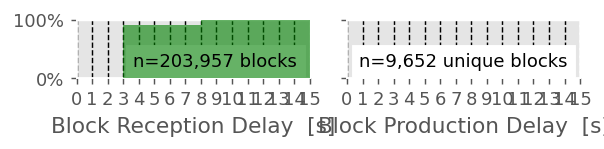

In [15]:
# display(EXP_multiple)
# EXP = EXP_multiple.value
# # display(EXP_drop)
# # EXP = EXP_drop.value
# print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
# df = create_df(EXP, 'block')
df = df_block
# df = df.get_param(df,'generic_params','block_period')
XMAX = 15

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create figure
fig, ax = plt.subplots(1,2, sharey=True, figsize=flhh)

# Create plot
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder= 3)
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder=3)
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[1].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
fig.tight_layout()
# plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

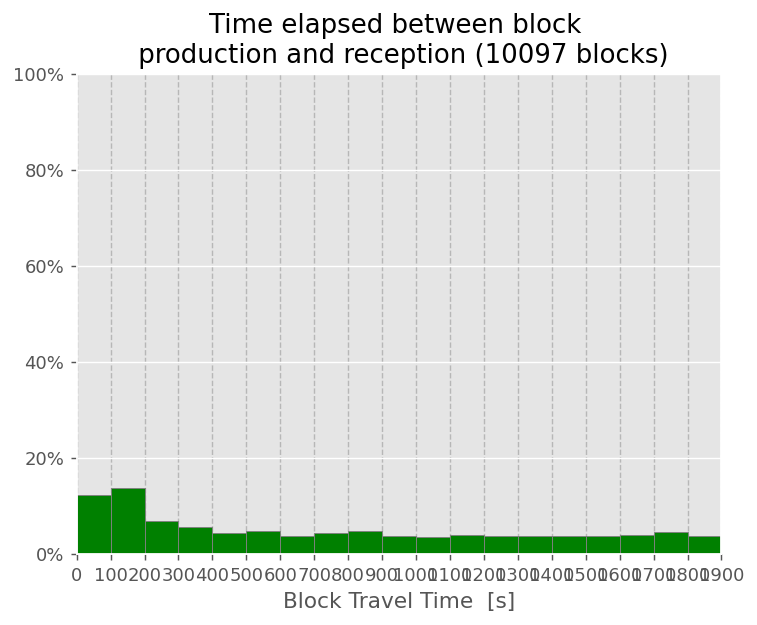

In [34]:
# display(EXP_drop)
# EXP = EXP_drop.value

# # Generate the dataframe
# df = create_df(EXP, 'block')
df = df_block
# df = df.get_param(df,'generic_params','block_period')
df['block_period'] = 100

# Process the data  
bins = range(0, 2000, 100)
XX = df.groupby('HASH')['TELAPSED'].agg('max')
# XX = df['TELAPSED']

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between consecutive blocks

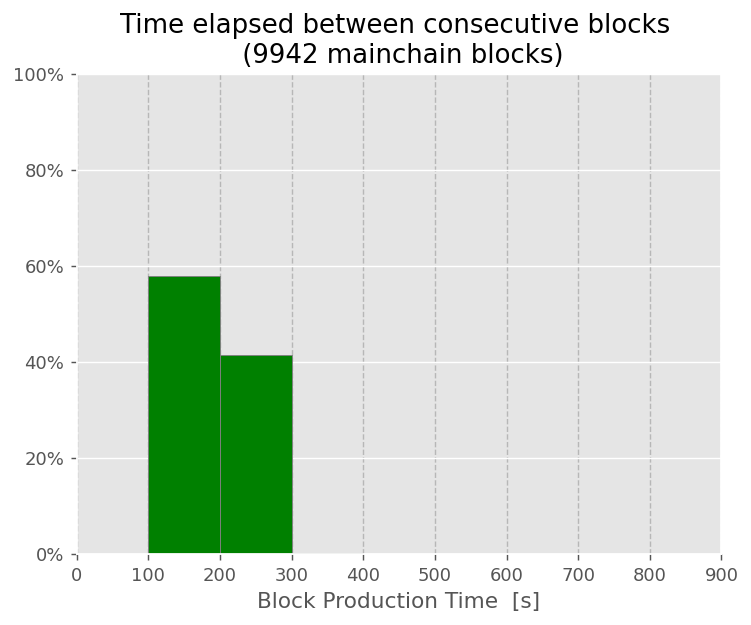

In [26]:
# # Generate the dataframe
# df = create_df(EXP, 'block')
df = df_block

# Process the dataframe  
# df = df.get_param(df,'generic_params','block_period')
bins = range(0, 1000, 100)

mainchains = get_mainchains(df)
df = df[df['HASH'].isin(mainchains)]
df = df.drop_duplicates('HASH')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Check how many blocks were produced

In [35]:
df = df_block

# Process the dataframe  
mainchains = get_mainchains(df)
df = df[df['HASH'].isin(mainchains)]
df = df.drop_duplicates('HASH')

display(df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({'BLOCK':'max'}))

,EXP,CFG,REP,BLOCK
0,test,test,001,333
1,test,test,002,350
2,test,test,003,336
3,test,test,004,361
4,test,test,005,346
5,test,test,006,347
6,test,test,007,353
7,test,test,008,347
8,test,test,009,349
9,test,test,010,306


## Reward V Time (plot)

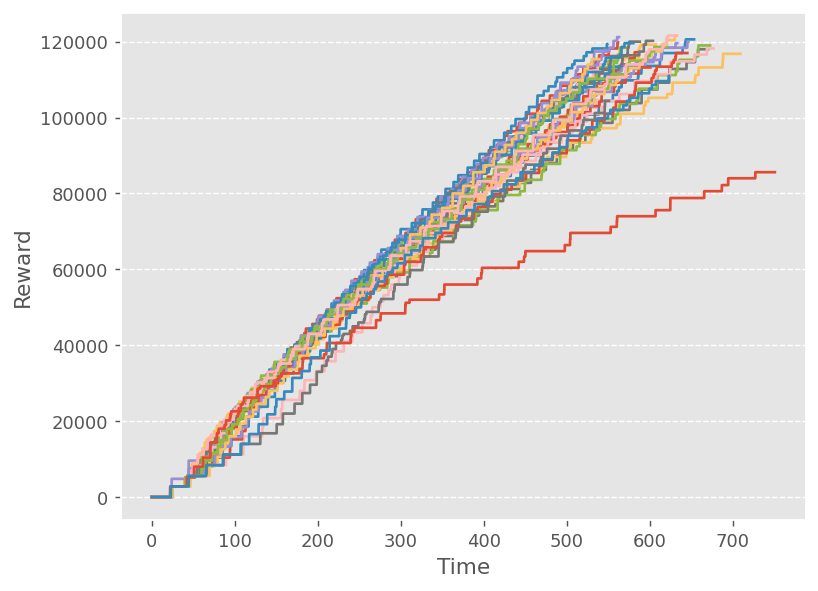

In [37]:
# Generate the dataframe
df = df_loop

# Plot options
XX = 'TIME'
YY = 'VALUE'
BP = 'Robots'
yl = 'Reward'
xl = 'Time'
fs = xm(2)*flwidth

# Process the data 
df = df.set_index(XX).groupby(EXP_CFG_REP)

# Create plot
ax = plt.axes()
df[YY].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()
# ax.legend()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Reward (boxplot)

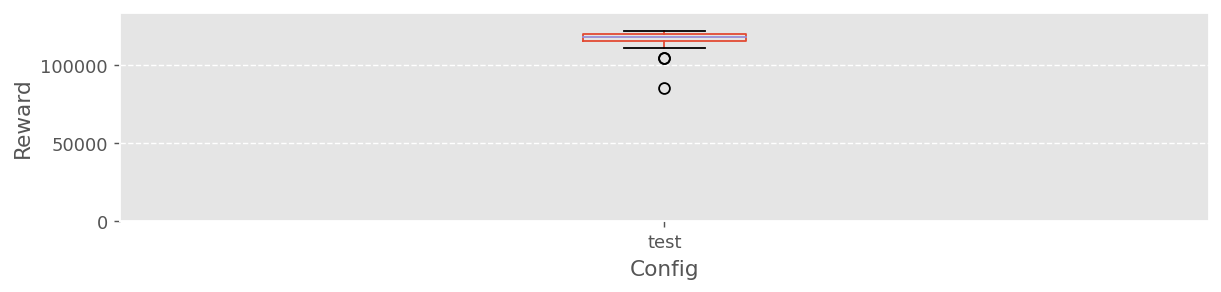

In [39]:
# Generate the dataframe
df = df_loop
# df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
# df = get_param_df(df, 'experiment', 'MAXWORKERS', alias = 'limit')
# df = get_param_df(df, 'experiment', 'EPSILON', alias = 'epsilon')

# Plot options
XX = 'CFG'
YY = 'VALUE'
BP = 'CFG'
yl = 'Reward'
xl = 'Config'
fs = xm(2)*flwidth

# Process the data 
df = df.groupby([]+EXP_CFG_REP, as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel(xl)
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Smart Contract (plot)

In [40]:
# Generate the dataframe
df = df_sc
# df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
# display(df)

# Plot options
XX = 'BLOCK'
YY = 'WCOUNT'
yl = 'Number of Workers'
xl = 'Block'
fs = double

# Process the data
df["XY"] = df["X"].astype(str)
+ df["Y"].astype(str)
df = df.drop_duplicates(['HASH','XY']).sort_values('BLOCK').reset_index()

main_leaf = df.iloc[-1]['HASH']
main_df = get_mainchain_df(df, main_leaf).reset_index()
df = df[df['HASH'].isin(main_df['HASH'])]

dfp = df[[YY, 'BLOCK','QLTY']].pivot(columns='QLTY', values=YY).fillna(0).astype(int)
dfp['BLOCK'] = df['BLOCK']
dfp = dfp.set_index('BLOCK')

# Create plot
ax = plt.axes()
dfp.groupby('BLOCK').agg('sum').plot.area(color=dfp.columns.values,linestyle='None', legend='None', ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('')   
ax.get_legend().remove()

# Save plot
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

,ID,TIME,TIMESTAMP,BLOCK,HASH,PHASH,BALANCE,TX_COUNT,EXP,CFG,REP,CONTROLLER
0,1,1.727256e+09,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0,0,test,test,001,test
1,1,1.727256e+09,100,1,9bd197739213cce026dbee04dd179d0b6abfd05ee31a5c...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,21,test,test,001,test
2,1,1.727256e+09,200,2,17e35aff2e9dd095b002c63a5fd4b1873e28f992d4874f...,9bd197739213cce026dbee04dd179d0b6abfd05ee31a5c...,0,21,test,test,001,test
3,1,1.727256e+09,300,3,0a9cbfbaf1483da22464d1ef0912f1117913c0c9d9d264...,17e35aff2e9dd095b002c63a5fd4b1873e28f992d4874f...,0,21,test,test,001,test
4,1,1.727256e+09,400,4,fc755c43a9a2dcbe45747d57646b1230403b62ccb0f821...,0a9cbfbaf1483da22464d1ef0912f1117913c0c9d9d264...,0,21,test,test,001,test
...,...,...,...,...,...,...,...,...,...,...,...,...
203952,9,1.727316e+09,49153,333,6674fffeef9ddf9b3ab1fc04908613a075781a35457b1d...,dc1556293e07fbfebe6cf4bed1a55826a9921fadc000c0...,0,95,test,test,030,test
203953,9,1.727316e+09,49280,334,9fd711d823e4f1874e0525ccabd6eef3514ea7d088f0ad...,6674fffeef9ddf9b3ab1fc04908613a075781a35457b1d...,0,95,test,test,030,test
203954,9,1.727316e+09,49380,335,e69239e0fa7d616ef6908b30e6cdc6c951981763ea8efe...,9fd711d823e4f1874e0525ccabd6eef3514ea7d088f0ad...,0,95,test,test,030,test
203955,9,1.727316e+09,49580,336,7f0fda5fb9a127d9cbff78006307c18023477f61fa0d53...,e69239e0fa7d616ef6908b30e6cdc6c951981763ea8efe...,0,95,test,test,030,test


In [48]:
display(df_firm)

,ID,TSTART,FC,Q,C,MC,TC,ATC,PROFIT,EXP,CFG,REP,CONTROLLER,Reward
0,12,3184,286,13,"[25, 60, 120, 205, 295, 410, 530, 675, 825, 98...","[35, 60, 85, 90, 115, 120, 145, 150, 155, 160,...",1856,143,744,test,test,001,test,200
1,12,5656,286,10,"[65, 150, 260, 380, 510, 645, 785, 940, 1110, ...","[85, 110, 120, 130, 135, 140, 155, 170, 215]",1611,161,389,test,test,001,test,200
2,12,7799,286,10,"[85, 190, 315, 450, 590, 735, 885, 1050, 1250,...","[105, 125, 135, 140, 145, 150, 165, 200, 235]",1771,177,229,test,test,001,test,200
3,12,10047,286,9,"[95, 200, 320, 455, 595, 740, 890, 1065, 1275]","[105, 120, 135, 140, 145, 150, 175, 210]",1561,173,239,test,test,001,test,200
4,12,12172,286,10,"[105, 210, 345, 490, 640, 795, 955, 1120, 1320...","[105, 135, 145, 150, 155, 160, 165, 200, 235]",1841,184,159,test,test,001,test,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,7,23158,276,7,"[105, 230, 380, 555, 730, 925, 1130]","[125, 150, 175, 175, 195, 205]",1406,201,-6,test,test,030,test,200
2848,7,24952,286,6,"[125, 280, 450, 645, 845, 1050]","[155, 170, 195, 200, 205]",1336,223,-136,test,test,030,test,200
2849,7,26847,286,7,"[150, 310, 480, 655, 835, 1030, 1250]","[160, 170, 175, 180, 195, 220]",1536,219,-136,test,test,030,test,200
2850,7,28831,286,6,"[155, 320, 490, 675, 875, 1100]","[165, 170, 185, 200, 225]",1386,231,-186,test,test,030,test,200


## Firm (plot)

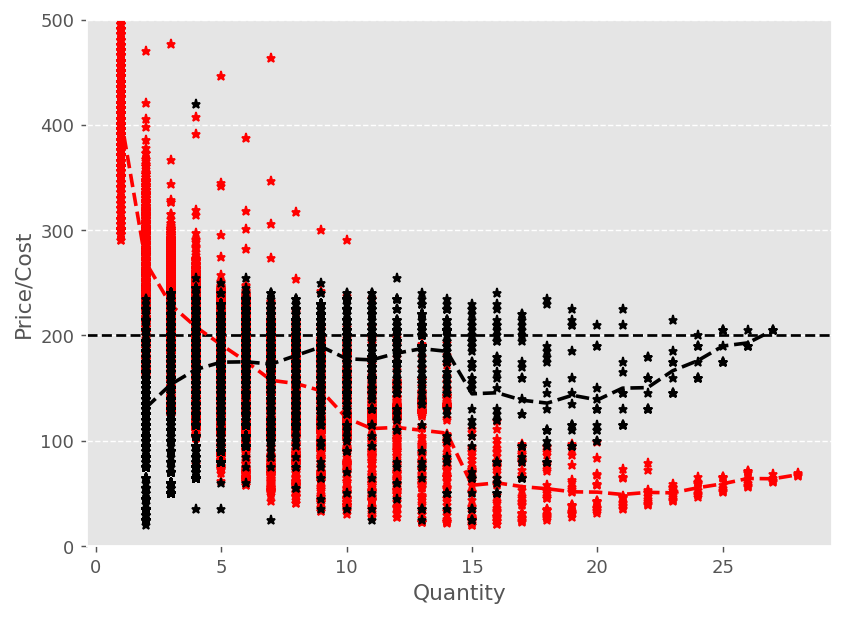

In [47]:
# Generate the dataframe
df = df_firm
# df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
# df = get_param_df(df, 'patches', 'utility', alias = 'Reward')
df['Reward'] = 200

# Plot options
XX = 'CFG'
YY = 'WCOUNT'
yl = 'Price/Cost'
xl = 'Quantity'
fs = double

del df['TIME']
df = df.set_index('TSTART')
# df = df.query('TIME>800')

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

plt.axhline(y = df['Reward'].mean(), color = 'k', linestyle = '--', label="Market Price")
label_mc, label_atc  = "Marginal Cost", "Average Total Cost"

# ## Average Total Cost
# dfa, i = pd.DataFrame(), 0
# for g,d in df.explode('C').groupby('TSTART'):
#     d.reset_index(inplace=True)
#     d.index += 1
#     ((d['C']+d['FC'])/d.index).plot(ax=ax, linestyle = '', linewidth = '0.2', marker='*', markersize='5', color = 'r', label=label_atc)
#     label_atc = "_nolegend_"
#     i+=1
#     dfa[str(i)] =(d['C']+d['FC'])/d.index

# ## Average Total Cost Mean
# dfa_mean = dfa.mean(axis=1)
# dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'r', label="ATC (mean)")

# dfa, i = pd.DataFrame(), 0

## Marginal Cost
for g,d in df.explode('MC').groupby('TSTART'):
    d.reset_index(inplace=True)
    d.index +=2
    (d['MC']).plot(ax=ax, linestyle = '', linewidth = '0.5',marker='*', markersize='5', color = 'k', label=label_mc)
    label_mc = "_nolegend_"
    i+=1
    dfa[str(i)] =d['MC']
    
# Marginal Cost Mean
dfa_mean = dfa.mean(axis=1)  
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'k', label="MC (mean)")

# for g,d in df.explode('C').groupby('TSTART'):
#     d.reset_index(inplace=True)
#     d.index += 1
#     (d['C']+d['FC']).plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='2.5', color = 'g')
    

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 500)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()

plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

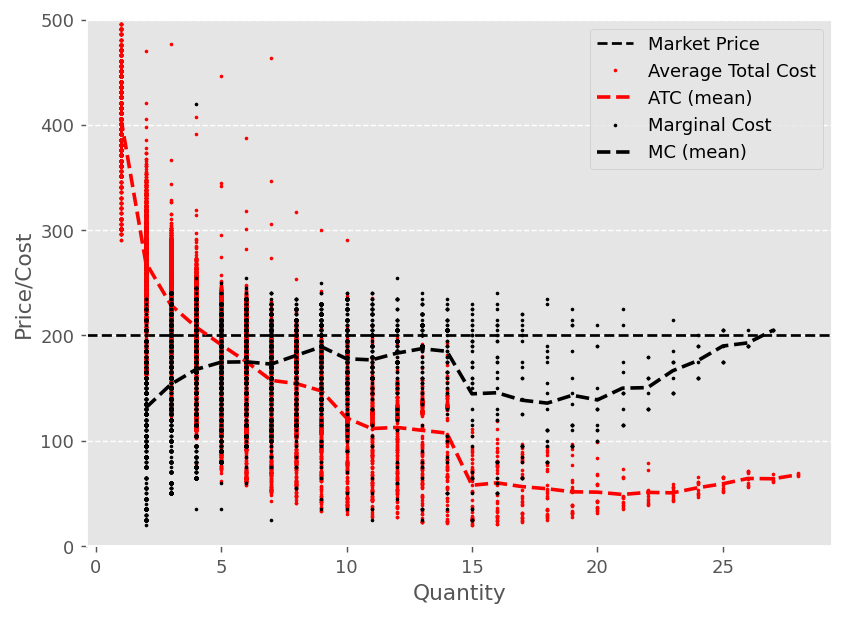

In [49]:
# Generate the dataframe
df = df_firm

# df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
# df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

# df['C']      = df.apply(lambda row: eval(row['C'].replace(',', ', ')), axis=1)
# df['MC']     = df.apply(lambda row: eval(row['MC'].replace(',', ', ')), axis=1)
# df['Reward'] = df.apply(lambda row: eval(row['Reward'])['blue'], axis=1)

df['Reward'] = 200

# Plot options
XX = 'CFG'
YY = 'WCOUNT'
yl = 'Price/Cost'
xl = 'Quantity'
fs = double

# df = df.query('TIME<800')
df['TIME'] = df['TSTART']
# df = df.query('TIME<20000')

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

plt.axhline(y = df['Reward'].mean(), color = 'k', linestyle = '--', label="Market Price")
label_mc, label_atc  = "Marginal Cost", "Average Total Cost"

# ## Actual Drops
# df.set_index('Q')['ATC'].plot(ax=ax, linestyle = '', linewidth = '0.5',marker='*', markersize='5', color = 'b', label="Actual")

## Average Total Cost
dfa, i = pd.DataFrame(), 0
for g,d in df.explode('C').groupby('TIME'):
    d.reset_index(inplace=True)
    d.index += 1
    ((d['C']+d['FC'])/d.index).plot(ax=ax, linestyle = '', linewidth = '0.2', marker='.', markersize='2', color = 'r', label=label_atc)
    label_atc = "_nolegend_"
    i+=1
    dfa[str(i)] =(d['C']+d['FC'])/d.index

## Average Total Cost Mean
dfa_mean = dfa.mean(axis=1)
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'r', label="ATC (mean)")

dfa, i = pd.DataFrame(), 0

## Marginal Cost
for g,d in df.explode('MC').groupby('TIME'):
    d.reset_index(inplace=True)
    d.index +=2
    (d['MC']).plot(ax=ax, linestyle = '', linewidth = '0.5',marker='.', markersize='2', color = 'k', label=label_mc)
    label_mc = "_nolegend_"
    i+=1
    dfa[str(i)] =d['MC']
    
## Marginal Cost Mean
dfa_mean = dfa.mean(axis=1)  
dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'k', label="MC (mean)")

    
# for g,d in df.explode('C').groupby('TIME'):
#     d.reset_index(inplace=True)
#     d.index += 1
#     (d['C']+d['FC']).plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='2.5', color = 'g')
    

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 500)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## SC (Balances)

GridspecLayout(children=(Dropdown(description='Exp:', index=1, layout=Layout(grid_area='widget001'), options=(…

Loaded dataframe: varyutil2 // datafile: sc


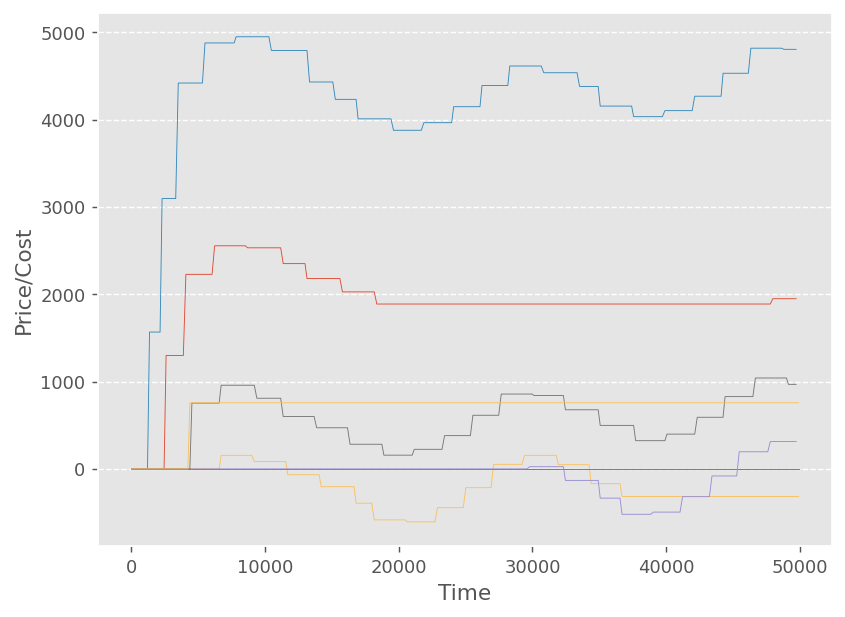

In [23]:
# Generate the dataframe
df = load_df('sc')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

# Plot options
XX = 'TIMESTAMP'
YY = 'BALANCE'
yl = 'Price/Cost'
xl = 'Time'
fs = double

# Corrections to dataframe
# df['BALANCE'] = df['QTTY']
df = df.set_index(XX)
# df['Reward'] = df.apply(lambda row: eval(row['Reward'])['blue'], axis=1)
# display(df)


# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

## Balance
df.groupby(['REP','ID'])[YY].plot(ax=ax, linestyle = '-', linewidth = '0.5', markersize='5')

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Epoch (Unit Cost over Time)

GridspecLayout(children=(Dropdown(description='Exp:', index=1, layout=Layout(grid_area='widget001'), options=(…

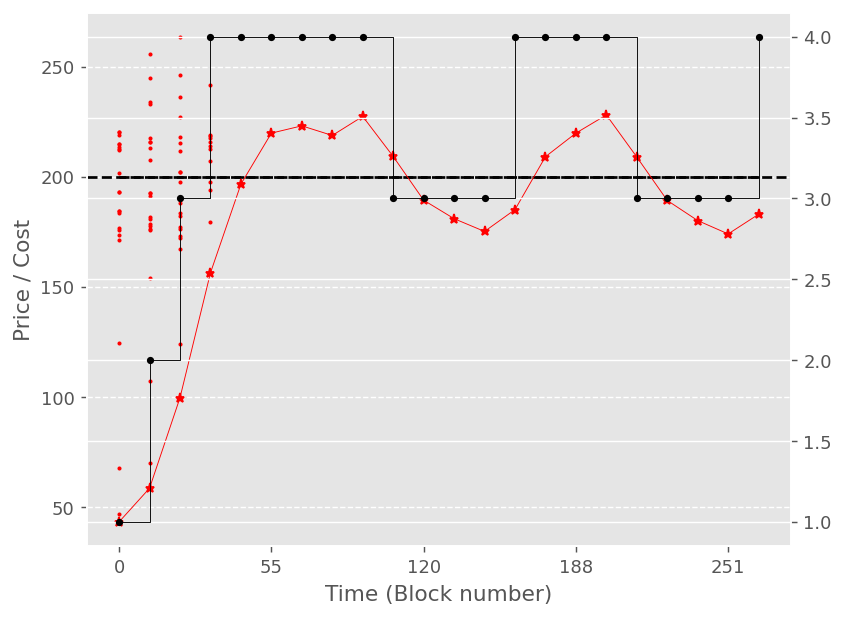

In [22]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')
# display(df)

# Plot options
XX = 'start'
YY = 'ATC'
yl = 'Price / Cost'
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Corrections to dataframe
df = df.drop_duplicates(subset=['NUMBER','BSTART', 'Q', 'TC'])
if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df = df.set_index(XX)            

# display(df)
# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

## Market price 
plt.axhline(y = df['utility'].mean(), color = 'k', linestyle = '--', label=labels[0])
df.groupby(['CFG','REP'])['MPRICE'].plot(ax=ax, linestyle = '--', color = 'k', label=labels[0])

## ATC 
df.explode(YY).groupby(XX)[YY].plot(ax=ax, linestyle = '', marker='.', markersize='2.5', color = 'r', label=labels[1])

## ATC 
YY = 'AATC'
df.groupby(['CFG','REP'])[YY].plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='5', color = 'r', label=labels[1])

## Workers
ax2 = ax.twinx() 
df.groupby(['CFG','REP'])['WORKERS'].plot(ax=ax2, drawstyle="steps-post", linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Epoch (Total Profit)

GridspecLayout(children=(Dropdown(description='Exp:', index=1, layout=Layout(grid_area='widget001'), options=(…

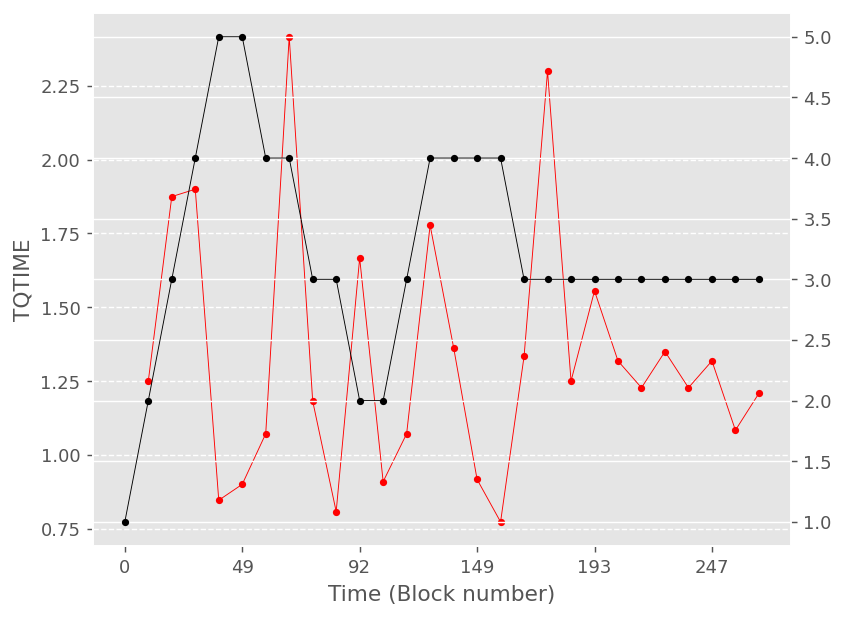

In [31]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Corrections to dataframe
df = df.drop_duplicates(subset=['NUMBER','BSTART', 'Q', 'TC'])
if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df['DURATION'] = df['start'].diff()

df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['TQPERROBO'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['TQTIME'] = df.apply(lambda row: row['TQ']/row['DURATION']/2, axis=1)
df['TREVENUE'] = df.apply(lambda row: sum([q*row['price']*row['utility'] for q in row['Q']]), axis=1)
df['TCOST'] = df.apply(lambda row: sum(row['TC']), axis=1)
df['TPROFIT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST']), axis=1)
df['TPROFITPERROBOT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/row['WORKERS'], axis=1)
df['TPROFITCUMSUM'] =  df.groupby('REP')['TPROFIT'].transform(pd.Series.cumsum)
df['TPROFITSCALED'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/100, axis=1)
df['TPROFITTIME'] = df.apply(lambda row: row['TPROFIT']/row['DURATION'], axis=1)

# Plot options
XX = 'start'
YY = 'TQTIME'
yl = YY
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

df.set_index(XX).groupby(['CFG','REP'])[YY].plot(ax=ax, linestyle = '-', marker='.', linewidth = '0.5', color = 'r', label=labels[1])

## Workers
ax2 = ax.twinx() 
df.set_index(XX).groupby(['CFG','REP'])['WORKERS'].plot(ax=ax2, linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)

ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)

plt.show()

## Epoch (Profit Boxplot)

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('varyutil…

,CFG,REP,TQ,TCOST,ATCOST
0,100,002,698,85689,122.76361


KeyError: 'start'

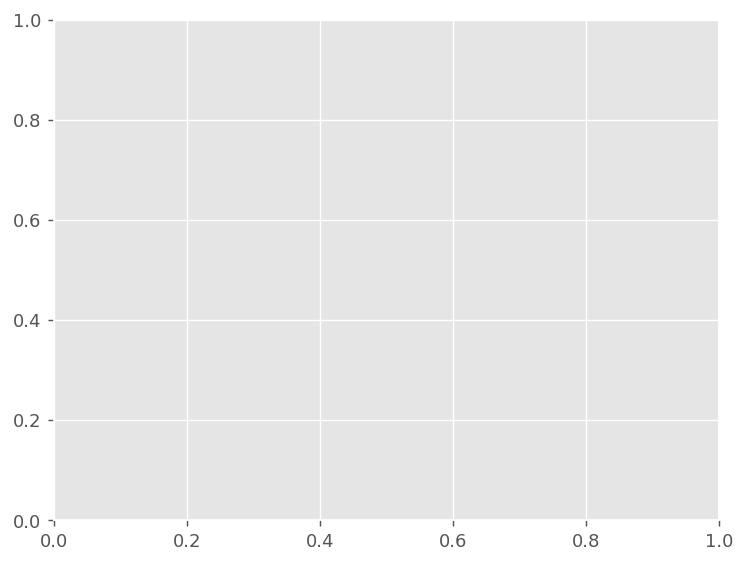

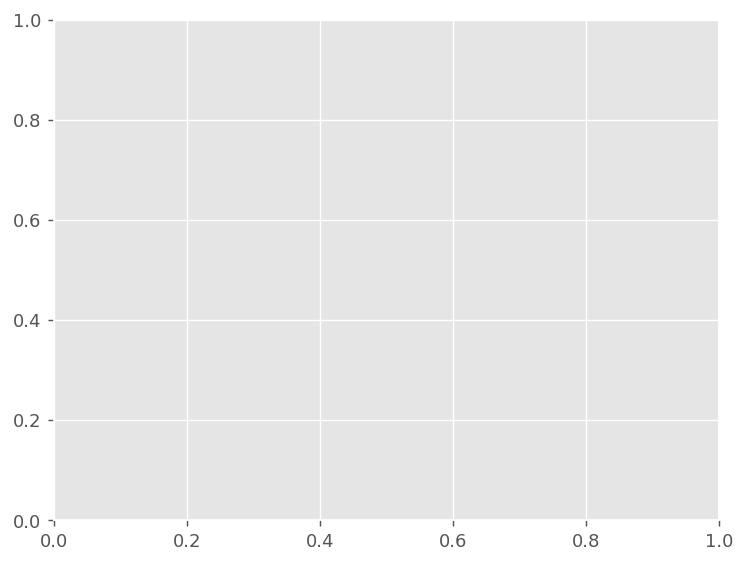

In [104]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Corrections to dataframe
df = df.drop_duplicates(subset=['NUMBER','BSTART', 'Q', 'TC'])
df['CFG'] = df['CFG'].astype('int')

if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df['DURATION'] = df['start'].diff()

df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['TQTIME'] = df.apply(lambda row: row['TQ']/row['DURATION']/2, axis=1)
df['TREVENUE'] = df.apply(lambda row: sum([q*row['price']*row['utility'] for q in row['Q']]), axis=1)
df['TCOST'] = df.apply(lambda row: sum(row['TC']), axis=1)
df['TPROFIT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST']), axis=1)
df['TPROFITPERROBOT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/row['WORKERS'], axis=1)
df['TPROFITCUMSUM'] =  df.groupby(['CFG','REP'])['TPROFIT'].transform(pd.Series.cumsum)
df['TPROFITSCALED'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/100, axis=1)
df['TPROFITTIME'] = df.apply(lambda row: row['TPROFIT']/row['DURATION'], axis=1)

# Plot options
# display(df[['ATC', 'AATC']])
XX = 'start'
YY = 'TQ'
BP = 'REP'
yl = YY
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()


df = df.groupby(['CFG', 'REP'], as_index=False).agg({YY:'sum', 'TCOST':'sum'})
df['ATCOST'] = df['TCOST']/df[YY]
display(df)

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))


# df.set_index(XX).groupby('REP')[YY].plot(ax=ax, linestyle = '-', marker='.', linewidth = '0.5', color = 'r', label=labels[1])

# ## Workers
# ax2 = ax.twinx() 
# df.set_index(XX).groupby('REP')['WORKERS'].plot(ax=ax2, linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)

ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Patches (Quantity)

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('varyutil…

Loaded dataframe: varyutil // datafile: patches


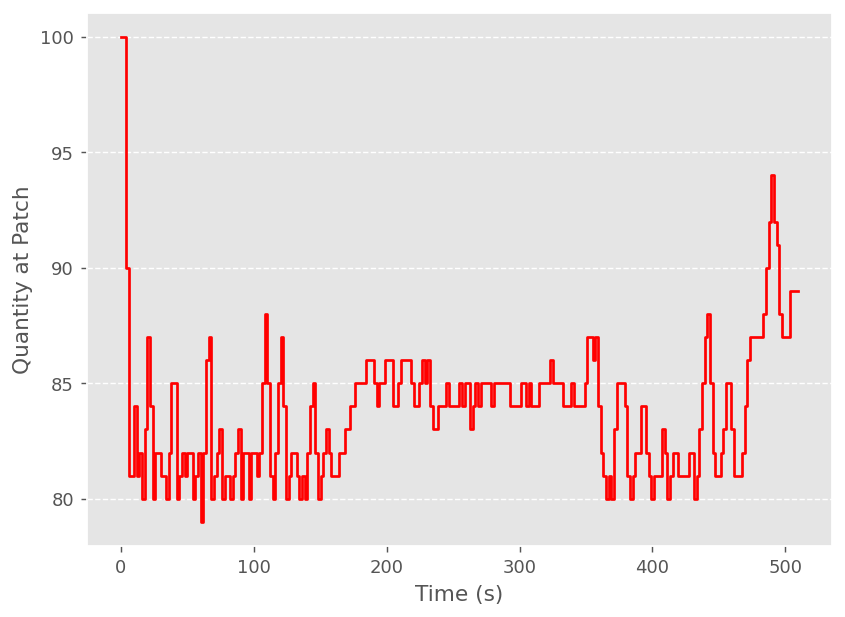

In [105]:
# Generate the dataframe
df = load_df('patches')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Plot options
XX = 'TIME'
YY = 'QTTY'
yl = 'Quantity at Patch'
xl = 'Time (s)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# df['QTTY'] = df.apply(lambda row: {x.split(':')[0]: x.split(':')[1] for x in row['JSON'].split(',')}['quantity'], axis=1)
df['QTTY'] = df.apply(lambda row: eval(row['JSON'])['quantity'], axis=1)

df = df.set_index(XX)  

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Quantity at patch
df['QTTY'].astype('int').plot(ax=ax, drawstyle="steps", linestyle = '-', color = 'r', label=labels[1])

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Ticks per second (histogram)

Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('varyutil',), value='varyutil')

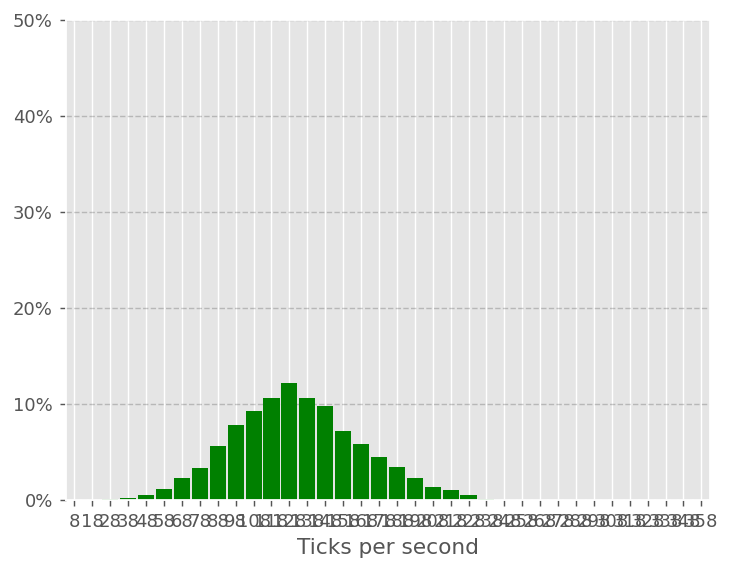

In [115]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'simulation')

# Process the dataframe 
step = 10
bins = np.arange(df['TPS'].min(), df['TPS'].max(), step)-step/2
xticks = np.arange(df['TPS'].min(), df['TPS'].max()+step, step)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPS'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])*0.9, color='green')

# Edit plot
ax.grid(axis='y', linestyle='--', color='k', alpha=0.2, zorder=0) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 0.5)
ax.set_xticks(xticks)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Ticks per second')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/ticks_per_second.png", bbox_inches='tight')
plt.show()

## Blockchain Visualizer (graph)

In [116]:
# Select which experiment to plot the whole blockchain
df = load_df('block')
df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()

# Process data
genesis = df['PHASH'].iloc[0]
main_leaf = df[df['TDIFF'] == df['TDIFF'].max()]['HASH'].iloc[0]

# Iterate from main_leaf to genesis -> mainchain
df_mainchain = get_mainchain_df(df, main_leaf)

# Block hashes not in the mainchain -> forks
df_forks = df.query("HASH not in @df_mainchain['HASH']")

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')


GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('varyutil…

Loaded dataframe: varyutil // datafile: block


In [117]:
TRIM_FORKS = 0

# fork_paths = [[y] for y in df_leafs['HASH']]
# df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)
# fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)
# nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)
# df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @df_mainchain['HASH']')

df_trimmed = trim_chain(df, TRIM_FORKS)
# display(df_trimmed)

bc = create_digraph(df)
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')


# # Do something cool? Idk, make all black for mini-plot
# df_trimmed.apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='black'), axis = 1)
# bc_trimmed.node(genesis, style='filled', fillcolor='black')

# # Do something cool? Idk, for example try to keep all forks at same level (slow!)
# df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
bc_trimmed.render('plots/blockchain', format='png', view=True)
bc_trimmed

## Working Income VS Staking Income

Dropdown(description='Experiment:', options=('130_staking', 'eco', 'stake'), value='130_staking')

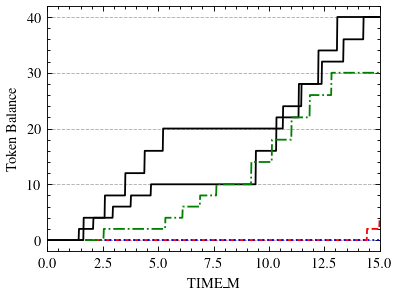

In [12]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'collection')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')


# REP = ['002']
# df = df.query("REP in @REP")

# Plot options
XX = 'TIME_M'
YY = [str(x) for x in range(1,int(df['Robots'].unique())+1)]
yl = 'Token Balance'
fs = hlwidth

# Process the data
df['SUM'] = df[YY].sum(axis=1)
df['TIME_M'] = df['TIME']/60

# Create plot
ax = plt.axes()
# fig,ax = plt.subplots(1,1,figsize=fs) 
# df.set_index([XX]).groupby(['ID','EXP','REP'])[YY].plot(ax=ax)
df.set_index([XX]).groupby(['REP'])['1'].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlim(xmin=0, xmax=15)
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
# plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()